In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate,Flatten,Lambda,Conv2D,BatchNormalization,Add,MaxPool2D,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model,Sequential
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop,Adam
from PIL import Image, ImageFont, ImageDraw
from keras import backend as K
# import seaborn as sns


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
!unzip '/kaggle/input/dogs-vs-cats/train.zip'

In [3]:
# ! rm -r '/kaggle/working/train'

In [4]:
# ! mkdir '/kaggle/working/train/cats'
# ! mkdir '/kaggle/working/train/dogs'

In [5]:
import os
import glob 
image = []
label = []
base_dir = '/kaggle/working'
train_path_content = os.listdir(f'{base_dir}/train')
print(f'train_size: {len(train_path_content)}')
train_dir = os.path.join(base_dir, 'train')

train_imgs = glob.glob(os.path.join(train_dir, "*"))
for img in train_imgs:
    image_name = os.path.splitext(os.path.basename(img))[0]
    if 'cat' in image_name:
    # move it to directory /content/train/cats
        image.append(img)
        label.append('cat')
    elif 'dog' in image_name:
    # move it to directory /content/train/dogs
        image.append(img)
        label.append('dog')
df = pd.DataFrame({'path':image,'label':label})        

train_size: 25000


In [6]:
df

,path,label
0,/kaggle/working/train/dog.970.jpg,dog
1,/kaggle/working/train/dog.10382.jpg,dog
2,/kaggle/working/train/cat.3654.jpg,cat
3,/kaggle/working/train/cat.7300.jpg,cat
4,/kaggle/working/train/dog.4620.jpg,dog
...,...,...
24995,/kaggle/working/train/cat.744.jpg,cat
24996,/kaggle/working/train/cat.7864.jpg,cat
24997,/kaggle/working/train/dog.142.jpg,dog
24998,/kaggle/working/train/cat.3260.jpg,cat


In [7]:
df['label'].value_counts()

dog    12500
cat    12500
Name: label, dtype: int64

In [11]:
# sns.countplot(x=df['label'])
# plt.show()

## Pre-Processing

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define the input shape expected by the model
input_shape = (150, 150, 3)

# Define the data generator
datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest',
                            validation_split=0.2)


train_generator = datagen.flow_from_dataframe(dataframe=df,
                                              directory=None,
                                              x_col='path',
                                              y_col='label',
                                              subset='training',
                                              target_size=input_shape[:2],
                                              batch_size=16,
                                              class_mode='categorical')

val_generator = datagen.flow_from_dataframe(dataframe=df,
                                            directory=None,
                                            x_col='path',
                                            y_col='label',
                                            subset='validation',
                                            target_size=input_shape[:2],
                                            batch_size=16,
                                            class_mode='categorical')


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Build Models

In [9]:
def plot_learning_curve(history):
    # Plot the training and validation accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot the training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [10]:
class CNNModel(tf.keras.Model):
    def __init__(self,layers,filters,kernel_size):
        super(CNNModel,self).__init__()
        self.conv     = [Conv2D(filters,kernel_size,padding='same') for _ in range(layers)]
        self.max_pool = [MaxPool2D((2,2)) for _ in range(layers)]
        self.act      = [tf.keras.layers.Activation('relu') for _ in range(layers)]
        self.conc      = Concatenate()
    def call(self,inputs):
        x = inputs
        for conv,max_,act in zip(self.conv,self.max_pool,self.act):
            x = conv(x)
            x = act(x)
            x = max_(x)
#         x = self.conc([x, inputs])
        return x

class DNNModel(tf.keras.Model):
    def __init__(self,layers,units,activation):
        super(DNNModel,self).__init__()
        
        self.hidden = [Dense(units,activation) for _ in range(layers)]
        self.out    = Dense(units = 2,activation ='softmax')
        self.dropout = Dropout(rate = 0.2)
        self.flat   = Flatten()
    def call(self,inputs):
        x  = self.flat(inputs)
        for layer in self.hidden:
            x = layer(x)
#             x = self.dropout(x)
        return self.out(x)    
            
        
class CustomModel(tf.keras.Model):
    def __init__(self,
                 cnn_layers,
                 filters,
                 kernel_size,
                 dnn_layers,
                 dnn_units,
                dnn_activation):
        super(CustomModel,self).__init__()
        self.block1 = CNNModel(cnn_layers,filters,kernel_size)
        self.block2 = DNNModel(dnn_layers,dnn_units,dnn_activation)
    def call (self,inputs):
        x = self.block1(inputs)
        x = self.block2(x)
        return x
    

In [27]:
# Load the ResNet50 model
# base_model = tf.keras.applications.ResNet50(weights='imagenet',
#                                             include_top=False,
#                                             input_shape=input_shape)

# # Freeze the base model layers
# for layer in base_model.layers:
#     layer.trainable = False

# model4 = tf.keras.Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(124, activation = "relu"),
#     Dense(64, activation = "relu"),
#     Dropout(0.2),
#     Dense(32, activation = "relu"),
#     Dense(16, activation = "relu"),
#     Dropout(0.2),
#     Dense(2, activation = "softmax")
# ])
# model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_19 (Dense)            (None, 124)               254076    
                                                                 
 dense_20 (Dense)            (None, 64)                8000      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                      

In [28]:
# model4.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# history = model4.fit(train_generator,
#                     epochs=10,
#                     validation_data=val_generator)

Epoch 1/10
1250/1250 [==============================] - 57s 41ms/step - loss: 0.6879 - accuracy: 0.5317 - val_loss: 0.6687 - val_accuracy: 0.5950
Epoch 2/10
1250/1250 [==============================] - 52s 41ms/step - loss: 0.6614 - accuracy: 0.5902 - val_loss: 0.6290 - val_accuracy: 0.6392
Epoch 3/10
1250/1250 [==============================] - 52s 41ms/step - loss: 0.6368 - accuracy: 0.6412 - val_loss: 0.6713 - val_accuracy: 0.5878
Epoch 4/10
1250/1250 [==============================] - 54s 43ms/step - loss: 0.6163 - accuracy: 0.6694 - val_loss: 0.5874 - val_accuracy: 0.6812
Epoch 5/10
1250/1250 [==============================] - 53s 42ms/step - loss: 0.6094 - accuracy: 0.6708 - val_loss: 0.5901 - val_accuracy: 0.6838
Epoch 6/10
1250/1250 [==============================] - 52s 41ms/step - loss: 0.5995 - accuracy: 0.6832 - val_loss: 0.5702 - val_accuracy: 0.7056
Epoch 7/10
1250/1250 [==============================] - 53s 42ms/step - loss: 0.5955 - accuracy: 0.6877 - val_loss: 0.5758 -

In [31]:
# plot_learning_curve(history)

In [43]:
# model5 = CustomModel(cnn_layers = 4,
#                filters=64,
#                kernel_size= 3,
#                dnn_layers = 3,
#               dnn_units = 32,
#               dnn_activation = 'relu')
# # model5.summary()
# model5.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# history = model5.fit(train_generator,
#                     epochs=10,
#                     validation_data=val_generator)

Epoch 1/10
1250/1250 [==============================] - 48s 36ms/step - loss: 0.6863 - accuracy: 0.5410 - val_loss: 0.6753 - val_accuracy: 0.5732
Epoch 2/10
1250/1250 [==============================] - 46s 37ms/step - loss: 0.6405 - accuracy: 0.6293 - val_loss: 0.5767 - val_accuracy: 0.6994
Epoch 3/10
1250/1250 [==============================] - 45s 36ms/step - loss: 0.5511 - accuracy: 0.7197 - val_loss: 0.4792 - val_accuracy: 0.7706
Epoch 4/10
1250/1250 [==============================] - 44s 36ms/step - loss: 0.4732 - accuracy: 0.7735 - val_loss: 0.4487 - val_accuracy: 0.7854
Epoch 5/10
1250/1250 [==============================] - 45s 36ms/step - loss: 0.4100 - accuracy: 0.8141 - val_loss: 0.3922 - val_accuracy: 0.8130
Epoch 6/10
1250/1250 [==============================] - 45s 36ms/step - loss: 0.3580 - accuracy: 0.8411 - val_loss: 0.3688 - val_accuracy: 0.8342
Epoch 7/10
1250/1250 [==============================] - 46s 37ms/step - loss: 0.3122 - accuracy: 0.8662 - val_loss: 0.4527 -

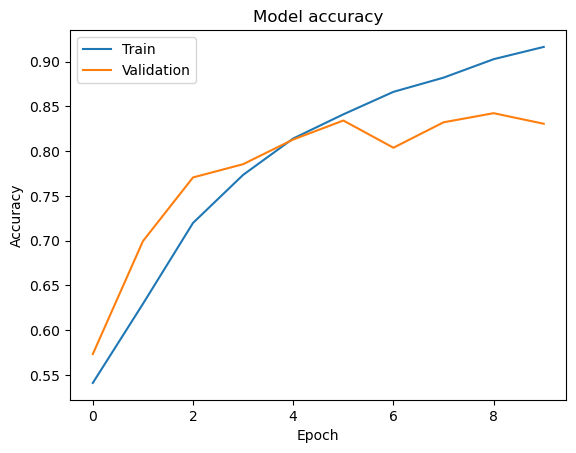

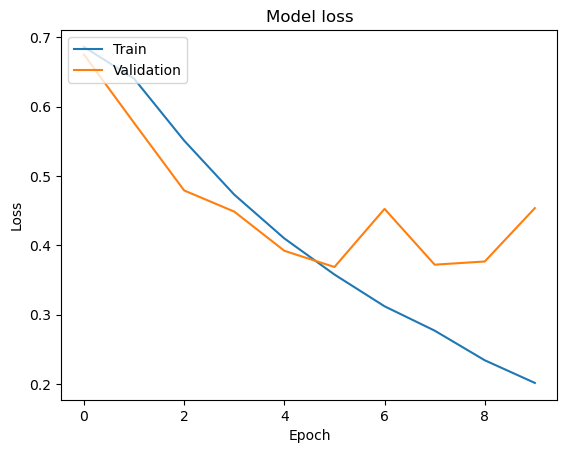

In [44]:
# plot_learning_curve(history)

In [12]:
class CNNModel2(tf.keras.Model):
    def __init__(self,layers,filters,kernel_size):
        super(CNNModel2,self).__init__()
        self.conv     = [Conv2D(filters,kernel_size,padding='same') for _ in range(layers)]
        self.max_pool = [MaxPool2D((2,2)) for _ in range(layers)]
        self.act      = [tf.keras.layers.Activation('relu') for _ in range(layers)]
        self.conc      = Concatenate()
    def call(self,inputs):
        x = inputs
        for conv,max_,act in zip(self.conv,self.max_pool,self.act):
            x = conv(x)
            x = act(x)
            x = max_(x)
#         x = self.conc([x, inputs])
        return x

class DNNModel2(tf.keras.Model):
    def __init__(self,layers,units,activation):
        super(DNNModel2,self).__init__()
        
        self.hidden = [Dense(units,activation) for _ in range(layers)]
        self.out    = Dense(units = 2,activation ='softmax')
        self.dropout = Dropout(rate = 0.2)
        self.flat   = Flatten()
    def call(self,inputs):
        x  = self.flat(inputs)
        for index,layer in enumerate(self.hidden):
            x = layer(x)
            if index != 0 and index%2==0:
                x = self.dropout(x)
        return self.out(x)    
            
        
class CustomModel2(tf.keras.Model):
    def __init__(self,
                 cnn_layers,
                 filters,
                 kernel_size,
                 dnn_layers,
                 dnn_units,
                dnn_activation):
        super(CustomModel2,self).__init__()
        self.block1 = CNNModel2(cnn_layers,filters,kernel_size)
        self.block2 = DNNModel2(dnn_layers,dnn_units,dnn_activation)
    def call (self,inputs):
        x = self.block1(inputs)
        x = self.block2(x)
        return x
    

In [10]:
# model6 = CustomModel2(cnn_layers = 4,
#                filters=64,
#                kernel_size= 3,
#                dnn_layers = 3,
#               dnn_units = 124,
#               dnn_activation = 'relu')
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# model6.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# history = model6.fit(train_generator,
#                     epochs=10,
#                     validation_data=val_generator,callbacks=[callback])

Epoch 1/10
1250/1250 [==============================] - 55s 39ms/step - loss: 0.6815 - accuracy: 0.5507 - val_loss: 0.6528 - val_accuracy: 0.6184
Epoch 2/10
1250/1250 [==============================] - 47s 38ms/step - loss: 0.5899 - accuracy: 0.6834 - val_loss: 0.5081 - val_accuracy: 0.7522
Epoch 3/10
1250/1250 [==============================] - 46s 37ms/step - loss: 0.4762 - accuracy: 0.7685 - val_loss: 0.4444 - val_accuracy: 0.7996
Epoch 4/10
1250/1250 [==============================] - 47s 38ms/step - loss: 0.4048 - accuracy: 0.8151 - val_loss: 0.4111 - val_accuracy: 0.8160
Epoch 5/10
1250/1250 [==============================] - 46s 37ms/step - loss: 0.3450 - accuracy: 0.8500 - val_loss: 0.4109 - val_accuracy: 0.8204
Epoch 6/10
1250/1250 [==============================] - 47s 38ms/step - loss: 0.2918 - accuracy: 0.8755 - val_loss: 0.4153 - val_accuracy: 0.8236
Epoch 7/10
1250/1250 [==============================] - 46s 37ms/step - loss: 0.2389 - accuracy: 0.9007 - val_loss: 0.4150 -

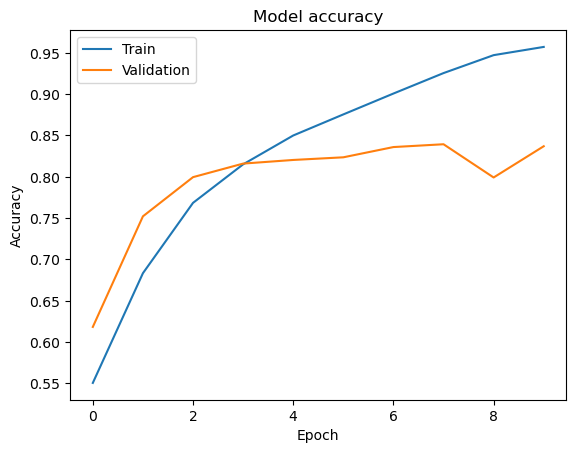

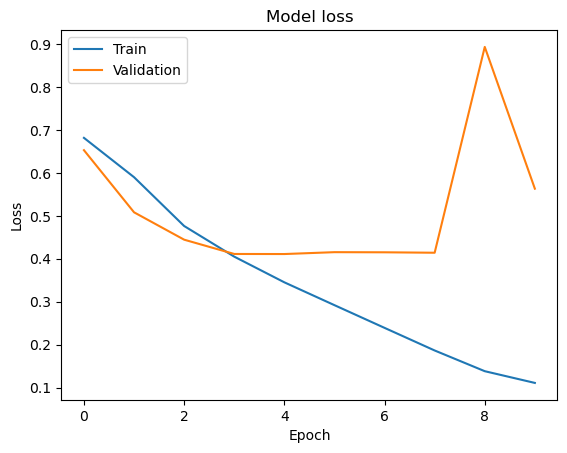

In [11]:
plot_learning_curve(history)

In [13]:
model7 = CustomModel2(cnn_layers = 4,
               filters=124,
               kernel_size= 3,
               dnn_layers = 1,
              dnn_units = 512,
              dnn_activation = 'relu')
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model7.fit(train_generator,
                    epochs=50,
                    validation_data=val_generator)

Epoch 1/50
1250/1250 [==============================] - 182s 141ms/step - loss: 0.6920 - accuracy: 0.5286 - val_loss: 0.6896 - val_accuracy: 0.5468
Epoch 2/50
1250/1250 [==============================] - 174s 139ms/step - loss: 0.6803 - accuracy: 0.5683 - val_loss: 0.6640 - val_accuracy: 0.5986
Epoch 3/50
1250/1250 [==============================] - 172s 138ms/step - loss: 0.6472 - accuracy: 0.6221 - val_loss: 0.6290 - val_accuracy: 0.6488
Epoch 4/50
1250/1250 [==============================] - 172s 138ms/step - loss: 0.5987 - accuracy: 0.6804 - val_loss: 0.5740 - val_accuracy: 0.6998
Epoch 5/50
1250/1250 [==============================] - 173s 138ms/step - loss: 0.5581 - accuracy: 0.7157 - val_loss: 0.5402 - val_accuracy: 0.7238
Epoch 6/50
1250/1250 [==============================] - 173s 138ms/step - loss: 0.5238 - accuracy: 0.7388 - val_loss: 0.5079 - val_accuracy: 0.7454
Epoch 7/50
1250/1250 [==============================] - 170s 136ms/step - loss: 0.4986 - accuracy: 0.7581 - val_

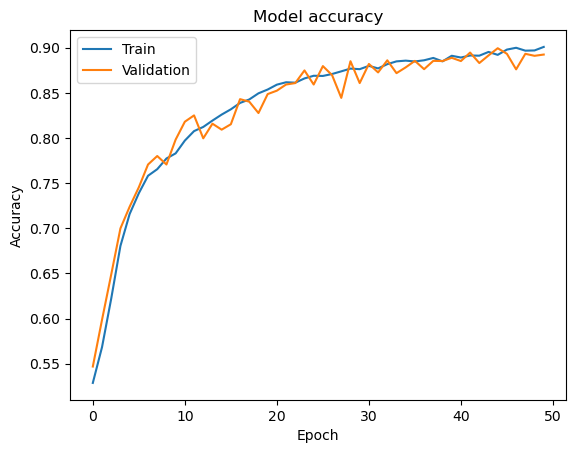

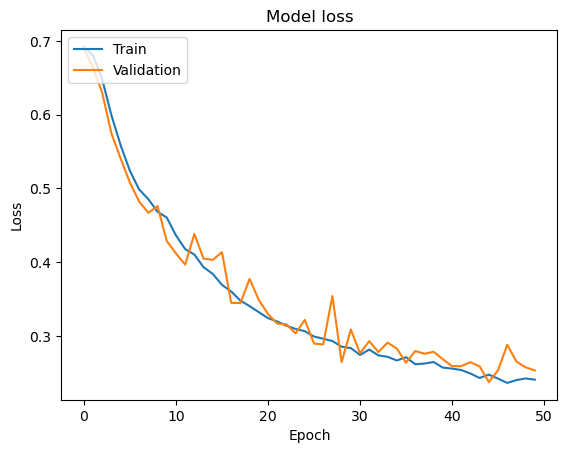

In [14]:
plot_learning_curve(history)

In [21]:
# assign location
path='/kaggle/working/Weights'
 
# save
model7.save_weights(path)

## Prepare Test Data

In [23]:
# ! unzip /kaggle/input/dogs-vs-cats/test1.zip

In [32]:
test_filenames = os.listdir("/kaggle/working/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(150,150),
    batch_size=16,
    shuffle=False
)

Found 12500 validated image filenames.


In [33]:
predict = model7.predict(test_generator)

782/782 [==============================] - 22s 28ms/step


In [34]:
predict

array([[8.5911103e-02, 9.1408885e-01],
       [1.0781617e-02, 9.8921835e-01],
       [4.1911867e-06, 9.9999583e-01],
       ...,
       [7.8147830e-05, 9.9992180e-01],
       [1.0415262e-01, 8.9584738e-01],
       [4.5429472e-02, 9.5457047e-01]], dtype=float32)

In [35]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((category,filename) for filename,category in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

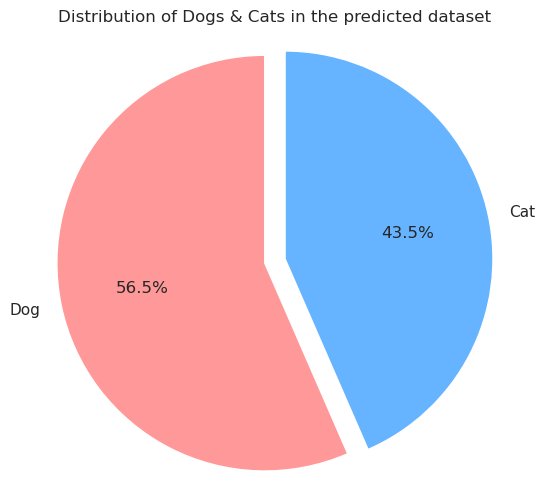

Dog: 7067 samples, 56.5%
Cat: 5433 samples, 43.5%


In [37]:
import seaborn as sns
category_counts = test_df['category'].value_counts()
category_percentages = category_counts / category_counts.sum() * 100

plt.figure(figsize=(6, 6))
sns.set(style='darkgrid')
labels = ['Dog', 'Cat']
colors = ['#ff9999', '#66b3ff']

explode = (0.1, 0)

plt.pie(category_counts, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Dogs & Cats in the predicted dataset')
plt.axis('equal')
plt.show()

for label, count, percentage in zip(labels, category_counts, category_percentages):
    print(f"{label}: {count} samples, {percentage:.1f}%")

In [38]:
test_df

,filename,category
0,10931.jpg,1
1,5819.jpg,1
2,10332.jpg,1
3,5402.jpg,1
4,4024.jpg,1
...,...,...
12495,8288.jpg,1
12496,7288.jpg,0
12497,7826.jpg,1
12498,9365.jpg,1


In [39]:
test_df.to_csv('submission.csv')